In [1]:
!pip install transformers
!pip install tensorflow
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system ==

In [36]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from tensorflow.keras.utils import pad_sequences

# Hugging Face Transformers – both generic and specific imports
import transformers as ppb
from transformers import (
    BertTokenizerFast,
    BertForMaskedLM,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW

from datasets import load_dataset
from datasets import Dataset

import warnings
# warnings.filterwarnings('ignore')


In [30]:
import torch

print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained BERT tokenizer and masked-LM model
from transformers import BertTokenizerFast, BertForMaskedLM

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
model = BertForMaskedLM.from_pretrained("bert-base-uncased")
model.to(device)


print("BERT tokenizer and MLM model loaded successfully!")
print(f"Model is on device: {device}")

CUDA Available: True
GPU: Tesla T4


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERT tokenizer and MLM model loaded successfully!
Model is on device: cuda


In [31]:
# set a seed for reproducibility
import json
import random

random.seed(2025)

# reservoir sample 50000 lines without loading the entire file into memory
k = 50000
sampled = []
with open("supercollider_dataset.jsonl", "r") as f:
    for i, line in enumerate(f):
        record = json.loads(line)
        if i < k:
            sampled.append(record)
        else:
            j = random.randint(0, i)
            if j < k:
                sampled[j] = record

# build DataFrame from sampled
df = pd.DataFrame(sampled)
print(f"Sampled {len(df)} examples")
display(df.sample(5))

# now tokenize
MAX_LEN = 128
tokenized_texts = df["text"].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True)
)

Sampled 50000 examples


,text
44054,"], 57120], 25562, ['/minibee/data ', 4, 0.4940..."
16027,Pbindef(\hicongaPT).stop;
43201,"##646]['/minibee/data ', 5, 0.52105969190598, ..."
32877,"8).abs).tanh, 0.3, 0.25+lfsaw.ar([sawrt*0.95, ..."
2982,~player.stopSparseRoutines(~indices2)SparseMat...


In [39]:
# 3. Pad / truncate to MAX_LEN
input_ids = pad_sequences(
    tokenized_texts.tolist(),
    maxlen=MAX_LEN,
    dtype="long",
    truncating="post",
    padding="post"
)

# 4. Build attention masks (1 for real tokens, 0 for padding)
attention_masks = np.where(input_ids != 0, 1, 0)

# 5. Convert to torch tensors
input_ids_tensor = torch.tensor(input_ids)
attention_masks_tensor = torch.tensor(attention_masks)

# 7. Create Dataset
dataset = Dataset.from_dict({
    "input_ids": input_ids,
    "attention_mask": attention_masks
})

train_dataset = dataset.train_test_split(test_size=0.1, seed=2025)["train"]
val_dataset = dataset.train_test_split(test_size=0.1, seed=2025)["test"]

In [40]:
from torch.cuda.amp import autocast, GradScaler

# 1) Setup
scaler = GradScaler()
epochs = 4
accum_steps = 2
batch_size = 32
effective_bs = batch_size * accum_steps
print(f"Effective batch size: {effective_bs}")

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15
)

train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=batch_size,
    collate_fn=data_collator
)

val_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=batch_size,
    collate_fn=data_collator
)

print(f"Train batches: {len(train_dataloader)}, Val batches: {len(val_dataloader)}")

Effective batch size: 64
Train batches: 1407, Val batches: 157


In [41]:
# Parameter grouping so that biases and layer‐norm params are not weight‐decayed
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {
        'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay': 0.01
    },
    {
        'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        'weight_decay': 0.0
    }
]

# Initialize optimizer using PyTorch’s AdamW
from torch.optim import AdamW
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5, eps=1e-8)


In [46]:
from tqdm import trange, tqdm

# Dataloaders
print(f"Train batches: {len(train_dataloader)}, Val batches: {len(val_dataloader)}")

# AMP scaler and accumulation setup
scaler = GradScaler()
epochs = 4
accum_steps = 2  # gradient accumulation steps
print(f"Effective batch size: {batch_size * accum_steps}")

train_loss_set = []

for epoch in trange(epochs, desc="Epoch", mininterval=10):
    # -------- Training --------
    model.train()
    total_train_loss = 0.0

    for step, batch in enumerate(tqdm(train_dataloader, desc="  Training")):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # forward & backward with mixed precision
        with autocast():
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=input_ids
            )
            loss = outputs.loss / accum_steps

        scaler.scale(loss).backward()

        # step optimizer once every accum_steps
        if (step + 1) % accum_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        train_loss_set.append(loss.item() * accum_steps)
        total_train_loss += loss.item() * accum_steps

        if (step + 1) % (100 // accum_steps) == 0:
            current = loss.item() * accum_steps
            print(f"    Step {step+1}/{len(train_dataloader)} — loss: {current:.4f}")

    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{epochs} — Avg train loss: {avg_train_loss:.4f}")

    # -------- Validation --------
    model.eval()
    total_eval_loss = 0.0

    for batch in tqdm(val_dataloader, desc="  Validation"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        with torch.no_grad(), autocast():
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=input_ids
            )
        total_eval_loss += outputs.loss.item()

    avg_val_loss = total_eval_loss / len(val_dataloader)
    print(f"Epoch {epoch+1}/{epochs} — Validation loss: {avg_val_loss:.4f}")

# -------- Save Fine-Tuned Model --------
output_dir = "./scbert-finetuned"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Saved fine-tuned model and tokenizer to: {output_dir}")


Train batches: 1407, Val batches: 157
Effective batch size: 64


  Training:   4%|▎         | 50/1407 [00:12<05:45,  3.93it/s]

    Step 50/1407 — loss: 0.0059



  Training:   7%|▋         | 100/1407 [00:24<05:40,  3.83it/s]

    Step 100/1407 — loss: 0.0020



  Training:  11%|█         | 150/1407 [00:37<05:14,  3.99it/s]

    Step 150/1407 — loss: 0.0065



  Training:  14%|█▍        | 200/1407 [00:49<04:56,  4.07it/s]

    Step 200/1407 — loss: 0.0052



  Training:  18%|█▊        | 250/1407 [01:01<04:37,  4.16it/s]

    Step 250/1407 — loss: 0.0051



  Training:  21%|██▏       | 300/1407 [01:13<04:31,  4.08it/s]

    Step 300/1407 — loss: 0.0026



  Training:  25%|██▍       | 350/1407 [01:25<04:22,  4.03it/s]

    Step 350/1407 — loss: 0.0031



  Training:  28%|██▊       | 400/1407 [01:38<04:13,  3.98it/s]

    Step 400/1407 — loss: 0.0103



  Training:  32%|███▏      | 450/1407 [01:50<04:00,  3.98it/s]

    Step 450/1407 — loss: 0.0031



  Training:  36%|███▌      | 500/1407 [02:02<03:46,  4.00it/s]

    Step 500/1407 — loss: 0.0073



  Training:  39%|███▉      | 550/1407 [02:14<03:33,  4.02it/s]

    Step 550/1407 — loss: 0.0104



  Training:  43%|████▎     | 600/1407 [02:27<03:18,  4.06it/s]

    Step 600/1407 — loss: 0.0012



  Training:  46%|████▌     | 650/1407 [02:39<03:06,  4.05it/s]

    Step 650/1407 — loss: 0.0012



  Training:  50%|████▉     | 700/1407 [02:51<02:56,  4.00it/s]

    Step 700/1407 — loss: 0.0044



  Training:  53%|█████▎    | 750/1407 [03:03<02:44,  3.98it/s]

    Step 750/1407 — loss: 0.0015



  Training:  57%|█████▋    | 800/1407 [03:15<02:33,  3.94it/s]

    Step 800/1407 — loss: 0.0026



  Training:  60%|██████    | 850/1407 [03:28<02:23,  3.89it/s]

    Step 850/1407 — loss: 0.0046



  Training:  64%|██████▍   | 900/1407 [03:40<02:08,  3.94it/s]

    Step 900/1407 — loss: 0.0043



  Training:  68%|██████▊   | 950/1407 [03:52<01:57,  3.88it/s]

    Step 950/1407 — loss: 0.0015



  Training:  71%|███████   | 1000/1407 [04:04<01:45,  3.86it/s]

    Step 1000/1407 — loss: 0.0057



  Training:  75%|███████▍  | 1050/1407 [04:17<01:31,  3.90it/s]

    Step 1050/1407 — loss: 0.0017



  Training:  78%|███████▊  | 1100/1407 [04:29<01:18,  3.90it/s]

    Step 1100/1407 — loss: 0.0045



  Training:  82%|████████▏ | 1150/1407 [04:41<01:05,  3.91it/s]

    Step 1150/1407 — loss: 0.0062



  Training:  85%|████████▌ | 1200/1407 [04:53<00:52,  3.92it/s]

    Step 1200/1407 — loss: 0.0050



  Training:  89%|████████▉ | 1250/1407 [05:06<00:40,  3.88it/s]

    Step 1250/1407 — loss: 0.0025



  Training:  92%|█████████▏| 1300/1407 [05:18<00:27,  3.95it/s]

    Step 1300/1407 — loss: 0.0007



  Training:  96%|█████████▌| 1350/1407 [05:30<00:14,  3.94it/s]

    Step 1350/1407 — loss: 0.0041



  Training: 100%|█████████▉| 1400/1407 [05:43<00:01,  3.94it/s]

    Step 1400/1407 — loss: 0.0058



  Training: 100%|██████████| 1407/1407 [05:44<00:00,  4.08it/s]


Epoch 1/4 — Avg train loss: 0.0044



Epoch:  25%|██▌       | 1/4 [05:57<17:52, 357.57s/it]

Epoch 1/4 — Validation loss: 0.0032



  Training:   4%|▎         | 50/1407 [00:12<05:44,  3.93it/s]

    Step 50/1407 — loss: 0.0062



  Training:   7%|▋         | 100/1407 [00:24<05:38,  3.86it/s]

    Step 100/1407 — loss: 0.0078



  Training:  11%|█         | 150/1407 [00:36<05:23,  3.88it/s]

    Step 150/1407 — loss: 0.0006



  Training:  14%|█▍        | 200/1407 [00:49<05:06,  3.94it/s]

    Step 200/1407 — loss: 0.0012



  Training:  18%|█▊        | 250/1407 [01:01<04:52,  3.95it/s]

    Step 250/1407 — loss: 0.0073



  Training:  21%|██▏       | 300/1407 [01:13<04:41,  3.93it/s]

    Step 300/1407 — loss: 0.0040



  Training:  25%|██▍       | 350/1407 [01:25<04:26,  3.97it/s]

    Step 350/1407 — loss: 0.0040



  Training:  28%|██▊       | 400/1407 [01:38<04:18,  3.89it/s]

    Step 400/1407 — loss: 0.0027



  Training:  32%|███▏      | 450/1407 [01:50<04:05,  3.90it/s]

    Step 450/1407 — loss: 0.0005



  Training:  36%|███▌      | 500/1407 [02:02<03:51,  3.91it/s]

    Step 500/1407 — loss: 0.0039



  Training:  39%|███▉      | 550/1407 [02:15<03:37,  3.95it/s]

    Step 550/1407 — loss: 0.0027



  Training:  43%|████▎     | 600/1407 [02:27<03:26,  3.90it/s]

    Step 600/1407 — loss: 0.0055



  Training:  46%|████▌     | 650/1407 [02:39<03:11,  3.96it/s]

    Step 650/1407 — loss: 0.0041



  Training:  50%|████▉     | 700/1407 [02:52<02:56,  4.00it/s]

    Step 700/1407 — loss: 0.0004



  Training:  53%|█████▎    | 750/1407 [03:04<02:44,  3.99it/s]

    Step 750/1407 — loss: 0.0037



  Training:  57%|█████▋    | 800/1407 [03:16<02:32,  3.98it/s]

    Step 800/1407 — loss: 0.0005



  Training:  60%|██████    | 850/1407 [03:29<02:18,  4.03it/s]

    Step 850/1407 — loss: 0.0023



  Training:  64%|██████▍   | 900/1407 [03:41<02:06,  4.01it/s]

    Step 900/1407 — loss: 0.0021



  Training:  68%|██████▊   | 950/1407 [03:53<01:53,  4.04it/s]

    Step 950/1407 — loss: 0.0040



  Training:  71%|███████   | 1000/1407 [04:06<01:42,  3.98it/s]

    Step 1000/1407 — loss: 0.0060



  Training:  75%|███████▍  | 1050/1407 [04:18<01:28,  4.05it/s]

    Step 1050/1407 — loss: 0.0020



  Training:  78%|███████▊  | 1100/1407 [04:30<01:16,  4.01it/s]

    Step 1100/1407 — loss: 0.0004



  Training:  82%|████████▏ | 1150/1407 [04:43<01:04,  3.96it/s]

    Step 1150/1407 — loss: 0.0022



  Training:  85%|████████▌ | 1200/1407 [04:55<00:52,  3.96it/s]

    Step 1200/1407 — loss: 0.0036



  Training:  89%|████████▉ | 1250/1407 [05:08<00:39,  4.01it/s]

    Step 1250/1407 — loss: 0.0004



  Training:  92%|█████████▏| 1300/1407 [05:20<00:26,  4.01it/s]

    Step 1300/1407 — loss: 0.0039



  Training:  96%|█████████▌| 1350/1407 [05:32<00:14,  4.00it/s]

    Step 1350/1407 — loss: 0.0054



  Training: 100%|█████████▉| 1400/1407 [05:45<00:01,  3.99it/s]

    Step 1400/1407 — loss: 0.0022



  Training: 100%|██████████| 1407/1407 [05:46<00:00,  4.06it/s]


Epoch 2/4 — Avg train loss: 0.0033



Epoch:  50%|█████     | 2/4 [11:58<11:58, 359.29s/it]

Epoch 2/4 — Validation loss: 0.0026



  Training:   4%|▎         | 50/1407 [00:12<05:40,  3.99it/s]

    Step 50/1407 — loss: 0.0021



  Training:   7%|▋         | 100/1407 [00:24<05:26,  4.00it/s]

    Step 100/1407 — loss: 0.0019



  Training:  11%|█         | 150/1407 [00:37<05:19,  3.93it/s]

    Step 150/1407 — loss: 0.0025



  Training:  14%|█▍        | 200/1407 [00:50<05:10,  3.89it/s]

    Step 200/1407 — loss: 0.0019



  Training:  18%|█▊        | 250/1407 [01:02<04:44,  4.07it/s]

    Step 250/1407 — loss: 0.0003



  Training:  21%|██▏       | 300/1407 [01:14<04:35,  4.02it/s]

    Step 300/1407 — loss: 0.0052



  Training:  25%|██▍       | 350/1407 [01:27<04:23,  4.01it/s]

    Step 350/1407 — loss: 0.0037



  Training:  28%|██▊       | 400/1407 [01:39<04:12,  3.99it/s]

    Step 400/1407 — loss: 0.0052



  Training:  32%|███▏      | 450/1407 [01:51<03:58,  4.01it/s]

    Step 450/1407 — loss: 0.0036



  Training:  36%|███▌      | 500/1407 [02:04<03:45,  4.01it/s]

    Step 500/1407 — loss: 0.0003



  Training:  39%|███▉      | 550/1407 [02:16<03:37,  3.94it/s]

    Step 550/1407 — loss: 0.0004



  Training:  43%|████▎     | 600/1407 [02:28<03:22,  3.99it/s]

    Step 600/1407 — loss: 0.0020



  Training:  46%|████▌     | 650/1407 [02:41<03:10,  3.97it/s]

    Step 650/1407 — loss: 0.0021



  Training:  50%|████▉     | 700/1407 [02:53<02:54,  4.04it/s]

    Step 700/1407 — loss: 0.0036



  Training:  53%|█████▎    | 750/1407 [03:06<02:45,  3.97it/s]

    Step 750/1407 — loss: 0.0020



  Training:  57%|█████▋    | 800/1407 [03:18<02:31,  4.00it/s]

    Step 800/1407 — loss: 0.0019



  Training:  60%|██████    | 850/1407 [03:30<02:19,  4.00it/s]

    Step 850/1407 — loss: 0.0037



  Training:  64%|██████▍   | 900/1407 [03:43<02:07,  3.98it/s]

    Step 900/1407 — loss: 0.0017



  Training:  68%|██████▊   | 950/1407 [03:55<01:55,  3.96it/s]

    Step 950/1407 — loss: 0.0034



  Training:  71%|███████   | 1000/1407 [04:07<01:42,  3.97it/s]

    Step 1000/1407 — loss: 0.0037



  Training:  75%|███████▍  | 1050/1407 [04:20<01:28,  4.01it/s]

    Step 1050/1407 — loss: 0.0019



  Training:  78%|███████▊  | 1100/1407 [04:32<01:15,  4.04it/s]

    Step 1100/1407 — loss: 0.0085



  Training:  82%|████████▏ | 1150/1407 [04:45<01:04,  3.98it/s]

    Step 1150/1407 — loss: 0.0002



  Training:  85%|████████▌ | 1200/1407 [04:57<00:52,  3.95it/s]

    Step 1200/1407 — loss: 0.0035



  Training:  89%|████████▉ | 1250/1407 [05:09<00:39,  3.98it/s]

    Step 1250/1407 — loss: 0.0017



  Training:  92%|█████████▏| 1300/1407 [05:22<00:26,  3.98it/s]

    Step 1300/1407 — loss: 0.0035



  Training:  96%|█████████▌| 1350/1407 [05:34<00:14,  3.98it/s]

    Step 1350/1407 — loss: 0.0003



  Training: 100%|█████████▉| 1400/1407 [05:47<00:01,  3.96it/s]

    Step 1400/1407 — loss: 0.0019



  Training: 100%|██████████| 1407/1407 [05:48<00:00,  4.04it/s]


Epoch 3/4 — Avg train loss: 0.0029



Epoch:  75%|███████▌  | 3/4 [17:59<06:00, 360.45s/it]

Epoch 3/4 — Validation loss: 0.0023



  Training:   4%|▎         | 50/1407 [00:12<05:40,  3.98it/s]

    Step 50/1407 — loss: 0.0002



  Training:   7%|▋         | 100/1407 [00:24<05:30,  3.95it/s]

    Step 100/1407 — loss: 0.0002



  Training:  11%|█         | 150/1407 [00:37<05:15,  3.99it/s]

    Step 150/1407 — loss: 0.0016



  Training:  14%|█▍        | 200/1407 [00:49<05:01,  4.00it/s]

    Step 200/1407 — loss: 0.0016



  Training:  18%|█▊        | 250/1407 [01:02<04:53,  3.95it/s]

    Step 250/1407 — loss: 0.0035



  Training:  21%|██▏       | 300/1407 [01:14<04:37,  3.98it/s]

    Step 300/1407 — loss: 0.0033



  Training:  25%|██▍       | 350/1407 [01:26<04:27,  3.95it/s]

    Step 350/1407 — loss: 0.0018



  Training:  28%|██▊       | 400/1407 [01:39<04:11,  4.00it/s]

    Step 400/1407 — loss: 0.0066



  Training:  32%|███▏      | 450/1407 [01:51<04:02,  3.94it/s]

    Step 450/1407 — loss: 0.0048



  Training:  36%|███▌      | 500/1407 [02:04<03:49,  3.96it/s]

    Step 500/1407 — loss: 0.0002



  Training:  39%|███▉      | 550/1407 [02:16<03:37,  3.94it/s]

    Step 550/1407 — loss: 0.0035



  Training:  43%|████▎     | 600/1407 [02:29<03:24,  3.95it/s]

    Step 600/1407 — loss: 0.0017



  Training:  46%|████▌     | 650/1407 [02:41<03:10,  3.97it/s]

    Step 650/1407 — loss: 0.0002



  Training:  50%|████▉     | 700/1407 [02:54<02:58,  3.95it/s]

    Step 700/1407 — loss: 0.0017



  Training:  53%|█████▎    | 750/1407 [03:06<02:44,  4.00it/s]

    Step 750/1407 — loss: 0.0033



  Training:  57%|█████▋    | 800/1407 [03:18<02:32,  3.98it/s]

    Step 800/1407 — loss: 0.0033



  Training:  60%|██████    | 850/1407 [03:31<02:21,  3.93it/s]

    Step 850/1407 — loss: 0.0016



  Training:  64%|██████▍   | 900/1407 [03:43<02:08,  3.95it/s]

    Step 900/1407 — loss: 0.0002



  Training:  68%|██████▊   | 950/1407 [03:56<01:55,  3.95it/s]

    Step 950/1407 — loss: 0.0018



  Training:  71%|███████   | 1000/1407 [04:08<01:42,  3.99it/s]

    Step 1000/1407 — loss: 0.0017



  Training:  75%|███████▍  | 1050/1407 [04:21<01:29,  3.99it/s]

    Step 1050/1407 — loss: 0.0017



  Training:  78%|███████▊  | 1100/1407 [04:33<01:17,  3.98it/s]

    Step 1100/1407 — loss: 0.0015



  Training:  82%|████████▏ | 1150/1407 [04:45<01:05,  3.91it/s]

    Step 1150/1407 — loss: 0.0019



  Training:  85%|████████▌ | 1200/1407 [04:58<00:53,  3.88it/s]

    Step 1200/1407 — loss: 0.0018



  Training:  89%|████████▉ | 1250/1407 [05:10<00:40,  3.88it/s]

    Step 1250/1407 — loss: 0.0032



  Training:  92%|█████████▏| 1300/1407 [05:23<00:27,  3.94it/s]

    Step 1300/1407 — loss: 0.0002



  Training:  96%|█████████▌| 1350/1407 [05:35<00:14,  3.90it/s]

    Step 1350/1407 — loss: 0.0019



  Training: 100%|█████████▉| 1400/1407 [05:48<00:01,  3.87it/s]

    Step 1400/1407 — loss: 0.0031



  Training: 100%|██████████| 1407/1407 [05:49<00:00,  4.02it/s]


Epoch 4/4 — Avg train loss: 0.0027



Epoch: 100%|██████████| 4/4 [24:02<00:00, 360.72s/it]


Epoch 4/4 — Validation loss: 0.0021
Saved fine-tuned model and tokenizer to: ./scbert-finetuned


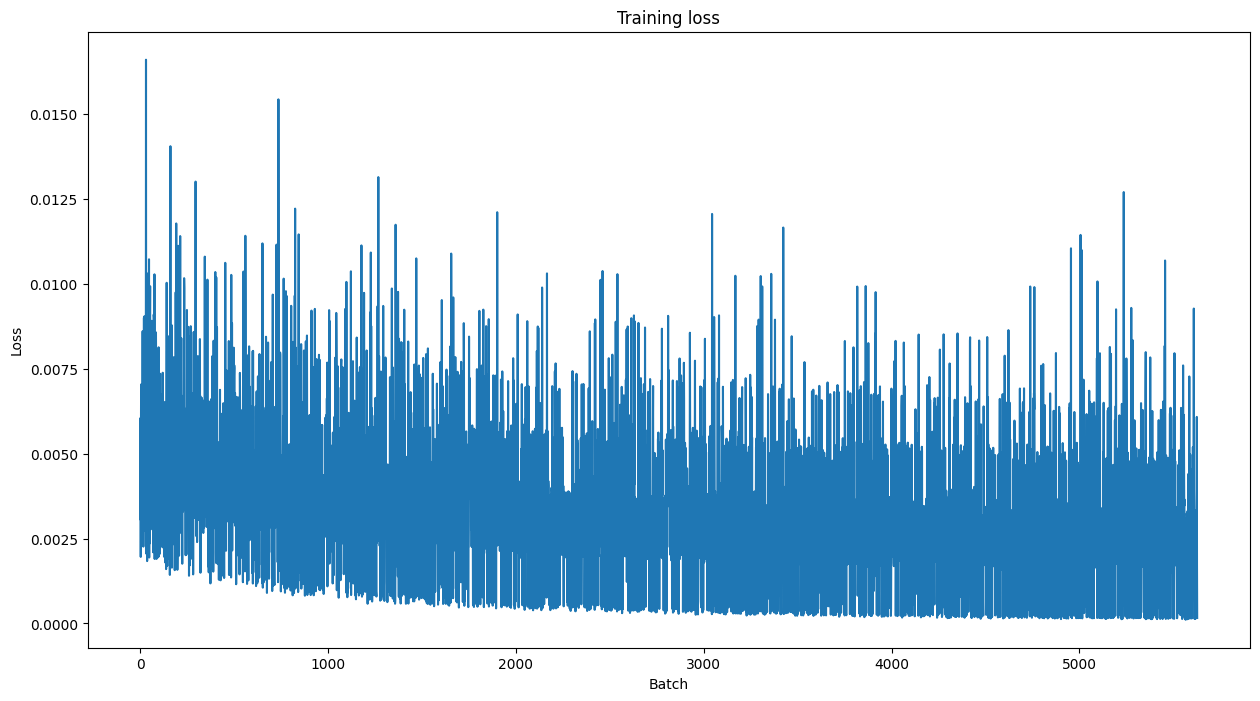

In [47]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [50]:
from transformers import BertForMaskedLM

# Load base model
base_model = BertForMaskedLM.from_pretrained("bert-base-uncased").to(device)
base_model.eval()

total_base_val_loss = 0

for batch in val_dataloader:
    b_input_ids = batch["input_ids"].to(device)
    b_input_mask = batch["attention_mask"].to(device)
    b_labels = batch["labels"].to(device)
    with torch.no_grad():
        outputs = base_model(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_base_val_loss += loss.item()

avg_base_val_loss = total_base_val_loss / len(val_dataloader)
print(f"Base model validation loss: {avg_base_val_loss:.4f}")
print(f"Fine-tuned model validation loss: {avg_val_loss:.4f}")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Base model validation loss: 2.7487
Fine-tuned model validation loss: 0.0021


In [55]:
import math

base_perplexity = math.exp(avg_base_val_loss)
fine_tuned_perplexity = math.exp(avg_val_loss)

print(f"Base model perplexity: {base_perplexity:.4f}")
print(f"Fine-tuned model perplexity: {fine_tuned_perplexity:.4f}")

Base model perplexity: 15.6216
Fine-tuned model perplexity: 1.0021


In [53]:
batch = next(iter(val_dataloader))
input_ids = batch["input_ids"].to(device)
attention_mask = batch["attention_mask"].to(device)
labels = batch["labels"].to(device)

for i in range(3):
    tokens = tokenizer.convert_ids_to_tokens(input_ids[i])
    print(" ".join(tokens))


[CLS] ev | if ( ev . char ##now = = $ f [MASK] { [MASK] . [MASK] } { 0 . 25 } } [MASK] \ [MASK] ##op [MASK] 1 _ interval , p ##fu ##nc [MASK] | ev | if ( [MASK] [MASK] char ##now = = $ f ) [MASK] 12 } [MASK] 7 } } [MASK] \ pitch ##op _ 1 _ amount , p ##fu ##nc [MASK] | ev | if ( ev . char ##now = = $ f ) { 0 . 1 } { 0 . [MASK] [MASK] } , [MASK] ) ; [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[CLS] [MASK] { lp ##f . ar ( in ##p [MASK] ar [MASK] l ##f [MASK] ##ise ##0 . k ##r ( [ 2 [MASK] 3 ] . choose ) . range ( 1000 , [MASK] [MASK] ) } [MASK] 22 * 0 . 5 } [MASK] comte > \ very [MASK] ##lp ##f ; [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

In [54]:
from torch.nn.functional import softmax

def top_k_accuracy(model, tokenizer, dataloader, k=5):
    correct = 0
    total = 0
    model.eval()

    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        mask_token_mask = input_ids == tokenizer.mask_token_id
        if not mask_token_mask.any(): continue

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

        masked_positions = mask_token_mask.nonzero(as_tuple=True)
        masked_logits = logits[masked_positions]
        masked_labels = input_ids[masked_positions]

        topk_preds = masked_logits.topk(k, dim=-1).indices
        correct += (topk_preds == masked_labels.unsqueeze(1)).any(dim=1).sum().item()
        total += masked_labels.size(0)

    return correct / total if total > 0 else None

# Example usage
acc_finetuned = top_k_accuracy(model, tokenizer, val_dataloader, k=5)
acc_base = top_k_accuracy(base_model, tokenizer, val_dataloader, k=5)
print(f"Top-5 Accuracy — Fine-tuned: {acc_finetuned:.3f}, Base: {acc_base:.3f}")


Top-5 Accuracy — Fine-tuned: 1.000, Base: 0.000
